In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime
import soundfile as sf

import audio_functions as af
import audio_models
import dataset
import model_functions as mf

Using TensorFlow backend.


In [2]:
importlib.reload(tf)

NameError: name 'python' is not defined

In [42]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
data_type = 'mag_phase_real_imag'

#checkpoint = '174/174-8'
#model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = 'C:/Users/Toby/Speech_Data/BG_test/tr05_bus_simu'
#directory_b = 'C:/Users/Toby/Speech_Data/BG_test/tr05_org'
#directory_c = 'C:/Users/Toby/Speech_Data/BG_test/tr05_bus_bg'

#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type == 'mag_real_imag':
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)
elif data_type == 'mag_phase_real_imag':
    mixed_input = mixed_spec[:, :, :-1, :]
    voice_input = voice_spec[:, :, :-1, :]

data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [43]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, '3Dunet', is_training, learning_rate, 
                                    data_type, name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


ValueError: Dimensions must be equal, but are 4 and 2 for 'Magnitude_Model/mul' (op: 'Mul') with input shapes: [?,256,512,4], [?,256,512,2].

In [44]:
enc = audio_models.UNet3DEncoder(mixed_input, is_training, reuse=False)
dec = audio_models.UNet3DDecoder(enc.output, enc, data_type, is_training, reuse=False)

In [45]:
print(enc.input_tensor.shape,'\n',
     enc.l1.shape,'\n',
     enc.l2.shape,'\n',
     enc.l3.shape,'\n',
     enc.l4.shape,'\n',
     enc.l5.shape,'\n',
     enc.output.shape)

(?, 256, 512, 4, 1) 
 (?, 128, 256, 4, 8) 
 (?, 64, 128, 4, 16) 
 (?, 32, 64, 4, 32) 
 (?, 16, 32, 4, 64) 
 (?, 8, 16, 4, 128) 
 (?, 4, 8, 4, 256)


In [46]:
print(dec.input_tensor.shape,'\n',
     dec.l1.shape,'\n',
     dec.l2.shape,'\n',
     dec.l3.shape,'\n',
     dec.l4.shape,'\n',
     dec.l5.shape,'\n',
     dec.output.shape)

(?, 4, 8, 4, 256) 
 (?, 8, 16, 4, 128) 
 (?, 16, 32, 4, 64) 
 (?, 32, 64, 4, 32) 
 (?, 64, 128, 4, 16) 
 (?, 128, 256, 4, 8) 
 (?, 256, 512, 4)


In [37]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 2000
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        _, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        #_, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        #epoch_m_loss.append(m_loss)
        #epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        #epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        #epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        #print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
        #                                                                       empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2018-11-08 13:58:31.509728
Epoch 0 finished. Mean cost = 0.2017301321029663
Epoch 1 finished. Mean cost = 0.1995924562215805
Epoch 2 finished. Mean cost = 0.19761906067530313
Epoch 3 finished. Mean cost = 0.19582470506429672
Epoch 4 finished. Mean cost = 0.19419961273670197
Epoch 5 finished. Mean cost = 0.19267289092143378
Epoch 6 finished. Mean cost = 0.1912126817873546
Epoch 7 finished. Mean cost = 0.18982177414000034
Epoch 8 finished. Mean cost = 0.18844352828131783
Epoch 9 finished. Mean cost = 0.1870959520339966
Epoch 10 finished. Mean cost = 0.1857723200863058
Epoch 11 finished. Mean cost = 0.18445201963186264
Epoch 12 finished. Mean cost = 0.18314175995496604
Epoch 13 finished. Mean cost = 0.18182590923139028
Epoch 14 finished. Mean cost = 0.1805225729942322
Epoch 15 finished. Mean cost = 0.17922477051615715
Epoch 16 finished. Mean cost = 0.17792591452598572
Epoch 17 finished. Mean cost = 0.17663095560338762
Epoch 18 finished. Mean cost = 0.17535209734188884
Epoch 19 fini

Epoch 162 finished. Mean cost = 0.09397161747414641
Epoch 163 finished. Mean cost = 0.0937681437992468
Epoch 164 finished. Mean cost = 0.09356436639121085
Epoch 165 finished. Mean cost = 0.09335665727954313
Epoch 166 finished. Mean cost = 0.09315023664942758
Epoch 167 finished. Mean cost = 0.09294552134261244
Epoch 168 finished. Mean cost = 0.09274271298089676
Epoch 169 finished. Mean cost = 0.0925406335031285
Epoch 170 finished. Mean cost = 0.09233991503279809
Epoch 171 finished. Mean cost = 0.09214061416339042
Epoch 172 finished. Mean cost = 0.09194309977179317
Epoch 173 finished. Mean cost = 0.09174676785438225
Epoch 174 finished. Mean cost = 0.09155261199389185
Epoch 175 finished. Mean cost = 0.09135877669111571
Epoch 176 finished. Mean cost = 0.0911670251838905
Epoch 177 finished. Mean cost = 0.09097636804989215
Epoch 178 finished. Mean cost = 0.090789254026373
Epoch 179 finished. Mean cost = 0.0906037626374099
Epoch 180 finished. Mean cost = 0.09041993235603221
Epoch 181 finished

Epoch 321 finished. Mean cost = 0.07370758721871036
Epoch 322 finished. Mean cost = 0.07363029421759833
Epoch 323 finished. Mean cost = 0.0735536363021827
Epoch 324 finished. Mean cost = 0.07347686561254355
Epoch 325 finished. Mean cost = 0.07340111294361346
Epoch 326 finished. Mean cost = 0.07332801744797543
Epoch 327 finished. Mean cost = 0.07325499267430931
Epoch 328 finished. Mean cost = 0.07318190866826516
Epoch 329 finished. Mean cost = 0.07310734918397484
Epoch 330 finished. Mean cost = 0.07303323340109828
Epoch 331 finished. Mean cost = 0.07296051771705409
Epoch 332 finished. Mean cost = 0.07288805525134634
Epoch 333 finished. Mean cost = 0.07281683835976138
Epoch 334 finished. Mean cost = 0.07274528354851167
Epoch 335 finished. Mean cost = 0.07267367457305747
Epoch 336 finished. Mean cost = 0.07260208488483458
Epoch 337 finished. Mean cost = 0.07253155588398319
Epoch 338 finished. Mean cost = 0.07246089737675535
Epoch 339 finished. Mean cost = 0.07239102588637787
Epoch 340 fin

Epoch 480 finished. Mean cost = 0.06492680231430674
Epoch 481 finished. Mean cost = 0.06488642452817982
Epoch 482 finished. Mean cost = 0.06484671005705375
Epoch 483 finished. Mean cost = 0.06480650796962917
Epoch 484 finished. Mean cost = 0.06476659101155616
Epoch 485 finished. Mean cost = 0.06472661425148754
Epoch 486 finished. Mean cost = 0.06468733862134221
Epoch 487 finished. Mean cost = 0.06464786033649914
Epoch 488 finished. Mean cost = 0.06460870649277067
Epoch 489 finished. Mean cost = 0.06456897922468428
Epoch 490 finished. Mean cost = 0.06452929786199707
Epoch 491 finished. Mean cost = 0.06448979452403823
Epoch 492 finished. Mean cost = 0.06445074840836061
Epoch 493 finished. Mean cost = 0.06441181351389239
Epoch 494 finished. Mean cost = 0.06437294132480717
Epoch 495 finished. Mean cost = 0.06433456029082017
Epoch 496 finished. Mean cost = 0.06429657352792185
Epoch 497 finished. Mean cost = 0.0642594748277621
Epoch 498 finished. Mean cost = 0.06422141752017285
Epoch 499 fin

Epoch 638 finished. Mean cost = 0.059846720423590224
Epoch 639 finished. Mean cost = 0.059820924000814554
Epoch 640 finished. Mean cost = 0.059795744217316184
Epoch 641 finished. Mean cost = 0.059770546284884304
Epoch 642 finished. Mean cost = 0.05974503937372894
Epoch 643 finished. Mean cost = 0.05971957373531153
Epoch 644 finished. Mean cost = 0.059694425952295925
Epoch 645 finished. Mean cost = 0.059669020727
Epoch 646 finished. Mean cost = 0.059643974830000626
Epoch 647 finished. Mean cost = 0.05961879277831794
Epoch 648 finished. Mean cost = 0.059593923039768806
Epoch 649 finished. Mean cost = 0.05956880484062892
Epoch 650 finished. Mean cost = 0.059543536744222116
Epoch 651 finished. Mean cost = 0.059518268463298954
Epoch 652 finished. Mean cost = 0.05949295278507389
Epoch 653 finished. Mean cost = 0.05946773264431807
Epoch 654 finished. Mean cost = 0.05944250293132913
Epoch 655 finished. Mean cost = 0.05941748184083802
Epoch 656 finished. Mean cost = 0.0593925992840592
Epoch 657

Epoch 795 finished. Mean cost = 0.05644485862672928
Epoch 796 finished. Mean cost = 0.056426728838397985
Epoch 797 finished. Mean cost = 0.05640850103644649
Epoch 798 finished. Mean cost = 0.056390451274355304
Epoch 799 finished. Mean cost = 0.05637208012863994
Epoch 800 finished. Mean cost = 0.05635365125689465
Epoch 801 finished. Mean cost = 0.056335084335390764
Epoch 802 finished. Mean cost = 0.056316762086314844
Epoch 803 finished. Mean cost = 0.05629864358227348
Epoch 804 finished. Mean cost = 0.056280736375299296
Epoch 805 finished. Mean cost = 0.05626251161209407
Epoch 806 finished. Mean cost = 0.05624450621330162
Epoch 807 finished. Mean cost = 0.05622649063254789
Epoch 808 finished. Mean cost = 0.056208898901607844
Epoch 809 finished. Mean cost = 0.05619084583480417
Epoch 810 finished. Mean cost = 0.056173076391514074
Epoch 811 finished. Mean cost = 0.05615551942234556
Epoch 812 finished. Mean cost = 0.056138059630678444
Epoch 813 finished. Mean cost = 0.05612022441145975
Epoc

Epoch 953 finished. Mean cost = 0.053923844498439656
Epoch 954 finished. Mean cost = 0.05390983026143144
Epoch 955 finished. Mean cost = 0.053895887404399684
Epoch 956 finished. Mean cost = 0.05388212820968533
Epoch 957 finished. Mean cost = 0.05386861931291528
Epoch 958 finished. Mean cost = 0.05385507860369553
Epoch 959 finished. Mean cost = 0.05384135804682349
Epoch 960 finished. Mean cost = 0.053827510582637836
Epoch 961 finished. Mean cost = 0.05381379482140784
Epoch 962 finished. Mean cost = 0.0537999836555832
Epoch 963 finished. Mean cost = 0.053786400110456954
Epoch 964 finished. Mean cost = 0.05377252906020441
Epoch 965 finished. Mean cost = 0.05375876809483853
Epoch 966 finished. Mean cost = 0.053744949307966874
Epoch 967 finished. Mean cost = 0.05373146638951518
Epoch 968 finished. Mean cost = 0.05371786361815883
Epoch 969 finished. Mean cost = 0.05370452081803809
Epoch 970 finished. Mean cost = 0.05369109191944253
Epoch 971 finished. Mean cost = 0.05367763422874144
Epoch 97

Epoch 1109 finished. Mean cost = 0.05199054120494439
Epoch 1110 finished. Mean cost = 0.05197938041749782
Epoch 1111 finished. Mean cost = 0.05196842972336591
Epoch 1112 finished. Mean cost = 0.051957241926419234
Epoch 1113 finished. Mean cost = 0.05194603727337916
Epoch 1114 finished. Mean cost = 0.05193490061925666
Epoch 1115 finished. Mean cost = 0.05192373727037702
Epoch 1116 finished. Mean cost = 0.05191258614550986
Epoch 1117 finished. Mean cost = 0.05190154688835997
Epoch 1118 finished. Mean cost = 0.051890783960713775
Epoch 1119 finished. Mean cost = 0.051879899170515796
Epoch 1120 finished. Mean cost = 0.05186922507930504
Epoch 1121 finished. Mean cost = 0.051858212214474585
Epoch 1122 finished. Mean cost = 0.05184728861558363
Epoch 1123 finished. Mean cost = 0.051836386147316456
Epoch 1124 finished. Mean cost = 0.05182557154695193
Epoch 1125 finished. Mean cost = 0.051814703932478626
Epoch 1126 finished. Mean cost = 0.05180413299756655
Epoch 1127 finished. Mean cost = 0.05179

Epoch 1263 finished. Mean cost = 0.050442136679717066
Epoch 1264 finished. Mean cost = 0.05043333155128796
Epoch 1265 finished. Mean cost = 0.050424396891682446
Epoch 1266 finished. Mean cost = 0.0504155524527829
Epoch 1267 finished. Mean cost = 0.05040631331620908
Epoch 1268 finished. Mean cost = 0.05039720462122895
Epoch 1269 finished. Mean cost = 0.05038804521300192
Epoch 1270 finished. Mean cost = 0.0503792875423664
Epoch 1271 finished. Mean cost = 0.05037011725699189
Epoch 1272 finished. Mean cost = 0.050361191003765536
Epoch 1273 finished. Mean cost = 0.05035204970492767
Epoch 1274 finished. Mean cost = 0.050342994358609706
Epoch 1275 finished. Mean cost = 0.05033381036876885
Epoch 1276 finished. Mean cost = 0.0503247526992833
Epoch 1277 finished. Mean cost = 0.05031571958464729
Epoch 1278 finished. Mean cost = 0.05030671988000061
Epoch 1279 finished. Mean cost = 0.05029773579153698
Epoch 1280 finished. Mean cost = 0.0502885523849079
Epoch 1281 finished. Mean cost = 0.05027953875

Epoch 1417 finished. Mean cost = 0.04914945238946355
Epoch 1418 finished. Mean cost = 0.04914171227146993
Epoch 1419 finished. Mean cost = 0.049134124629199506
Epoch 1420 finished. Mean cost = 0.04912636901221168
Epoch 1421 finished. Mean cost = 0.049118645075294703
Epoch 1422 finished. Mean cost = 0.049110944117782655
Epoch 1423 finished. Mean cost = 0.04910331830026561
Epoch 1424 finished. Mean cost = 0.049095692292117236
Epoch 1425 finished. Mean cost = 0.049088245853363716
Epoch 1426 finished. Mean cost = 0.04908051748238582
Epoch 1427 finished. Mean cost = 0.04907287416734448
Epoch 1428 finished. Mean cost = 0.0490651105076304
Epoch 1429 finished. Mean cost = 0.04905755113732148
Epoch 1430 finished. Mean cost = 0.0490500313561126
Epoch 1431 finished. Mean cost = 0.049042438796861876
Epoch 1432 finished. Mean cost = 0.04903488429958639
Epoch 1433 finished. Mean cost = 0.04902735315367185
Epoch 1434 finished. Mean cost = 0.04901997258802324
Epoch 1435 finished. Mean cost = 0.0490123

Epoch 1572 finished. Mean cost = 0.04803883063370683
Epoch 1573 finished. Mean cost = 0.048032153873518585
Epoch 1574 finished. Mean cost = 0.048025548046543486
Epoch 1575 finished. Mean cost = 0.04801893686440768
Epoch 1576 finished. Mean cost = 0.04801235182627742
Epoch 1577 finished. Mean cost = 0.04800585247056868
Epoch 1578 finished. Mean cost = 0.04799951606107483
Epoch 1579 finished. Mean cost = 0.047992873340373554
Epoch 1580 finished. Mean cost = 0.04798626448490211
Epoch 1581 finished. Mean cost = 0.04797955852957953
Epoch 1582 finished. Mean cost = 0.04797303015560345
Epoch 1583 finished. Mean cost = 0.047966377682645216
Epoch 1584 finished. Mean cost = 0.04795979762020924
Epoch 1585 finished. Mean cost = 0.04795327832661616
Epoch 1586 finished. Mean cost = 0.0479468343158563
Epoch 1587 finished. Mean cost = 0.04794021192187401
Epoch 1588 finished. Mean cost = 0.04793369035541899
Epoch 1589 finished. Mean cost = 0.0479270616370552
Epoch 1590 finished. Mean cost = 0.047920414

Epoch 1726 finished. Mean cost = 0.04708217251150679
Epoch 1727 finished. Mean cost = 0.047076444107073324
Epoch 1728 finished. Mean cost = 0.04707060503935524
Epoch 1729 finished. Mean cost = 0.04706483963295559
Epoch 1730 finished. Mean cost = 0.04705908367704064
Epoch 1731 finished. Mean cost = 0.04705337675043122
Epoch 1732 finished. Mean cost = 0.04704755099691274
Epoch 1733 finished. Mean cost = 0.0470418434594398
Epoch 1734 finished. Mean cost = 0.04703611160604342
Epoch 1735 finished. Mean cost = 0.047030591056145696
Epoch 1736 finished. Mean cost = 0.04702474502015539
Epoch 1737 finished. Mean cost = 0.04701894662322603
Epoch 1738 finished. Mean cost = 0.047013166921278604
Epoch 1739 finished. Mean cost = 0.04700745553548994
Epoch 1740 finished. Mean cost = 0.04700166290002195
Epoch 1741 finished. Mean cost = 0.04699591768800733
Epoch 1742 finished. Mean cost = 0.04699019807734438
Epoch 1743 finished. Mean cost = 0.04698450470326144
Epoch 1744 finished. Mean cost = 0.046978753

Epoch 1882 finished. Mean cost = 0.046231952270832204
Epoch 1883 finished. Mean cost = 0.04622684756883137
Epoch 1884 finished. Mean cost = 0.04622186488751075
Epoch 1885 finished. Mean cost = 0.04621670327977942
Epoch 1886 finished. Mean cost = 0.04621155428733217
Epoch 1887 finished. Mean cost = 0.04620638477687045
Epoch 1888 finished. Mean cost = 0.04620133634398323
Epoch 1889 finished. Mean cost = 0.046196224928769486
Epoch 1890 finished. Mean cost = 0.04619112642534128
Epoch 1891 finished. Mean cost = 0.04618598067302091
Epoch 1892 finished. Mean cost = 0.04618094708008925
Epoch 1893 finished. Mean cost = 0.04617576814456248
Epoch 1894 finished. Mean cost = 0.04617055415478105
Epoch 1895 finished. Mean cost = 0.04616538199442852
Epoch 1896 finished. Mean cost = 0.0461603197837165
Epoch 1897 finished. Mean cost = 0.04615520146156262
Epoch 1898 finished. Mean cost = 0.046150082709555125
Epoch 1899 finished. Mean cost = 0.046144954842564305
Epoch 1900 finished. Mean cost = 0.04613986

In [38]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, mask, voice_wave, mix_wave = sess.run([model.mixed_input, 
                                                                                 model.mixed_phase, 
                                                                                 model.voice_input,
                                                                                 model.gen_voice, 
                                                                                 model.voice_mask, 
                                                                                 model.voice_audio, 
                                                                                 model.mixed_audio],
                                                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     #fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
                                     #fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T)
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

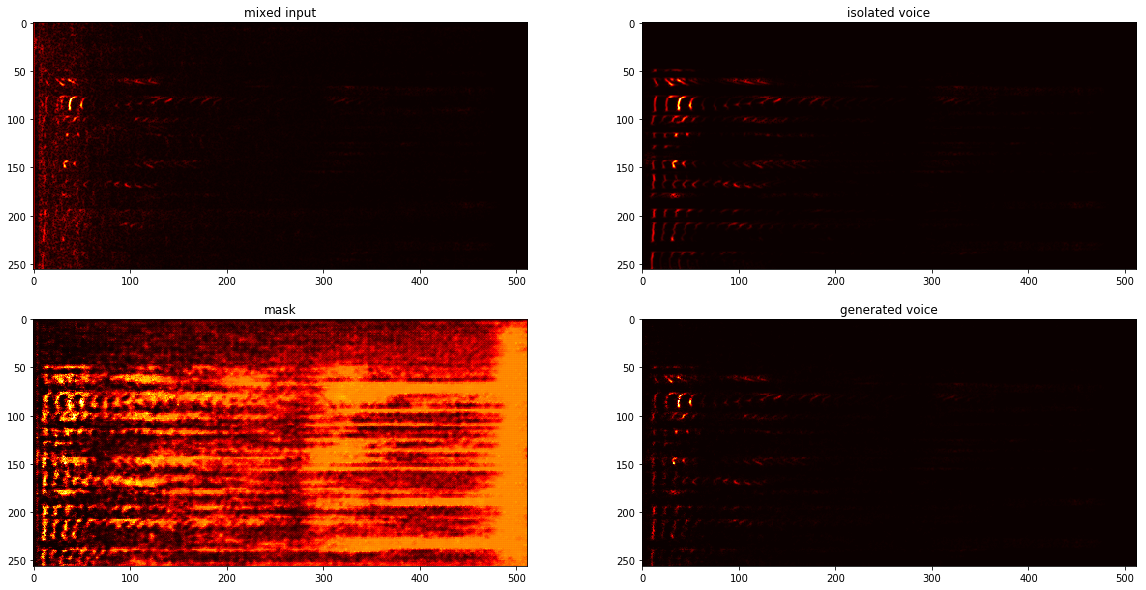

In [39]:
i=0

fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_inp[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est[i,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

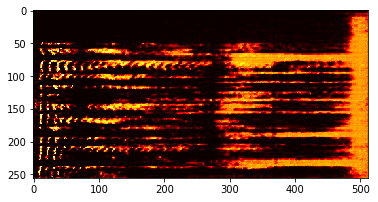

In [40]:
plt.imshow(mask[i,:,:,1])

In [31]:
i=0
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

1
65280


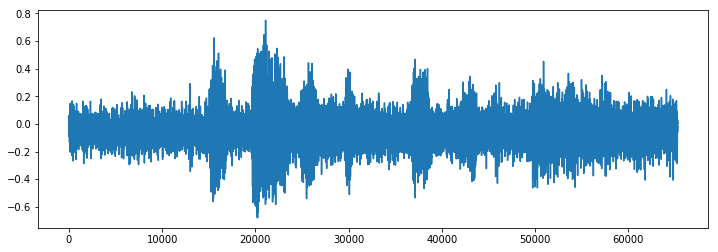

In [32]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

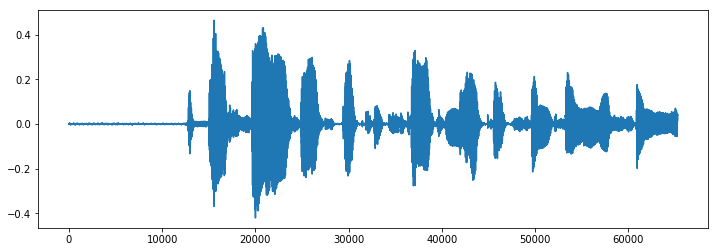

In [33]:
#  The true isolated voice 
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

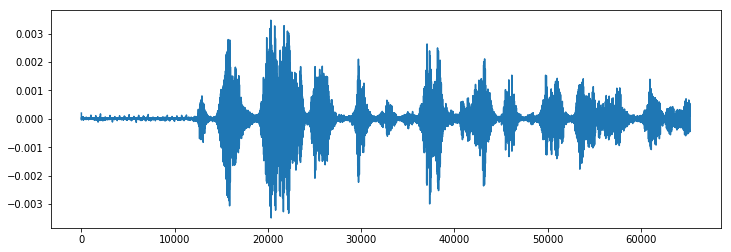

In [41]:
#  The estimated isolated voice produced by the network - real_imag
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)